In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications import VGG19,VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
import cv2
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import load_model # to save the model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.random import set_seed

import requests
import urllib
from io import BytesIO
from PIL import Image

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 60
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [3]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set the dataset path in Google Drive
# Change this path to where your dataset folder is stored in your Drive
DATA_PATH = '/content/drive/MyDrive/Tea Leaf Updated'

Mounted at /content/drive


In [4]:
#Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
data_dir = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_PATH,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
)

Found 2497 files belonging to 4 classes.


In [6]:
class_names = data_dir.class_names
print(f"Class names: {class_names}")
print(f"Dataset len: {len(data_dir)}")

Class names: ['Blight', 'Healthy_Leaf', 'Helopeltis', 'Red_Rust']
Dataset len: 79


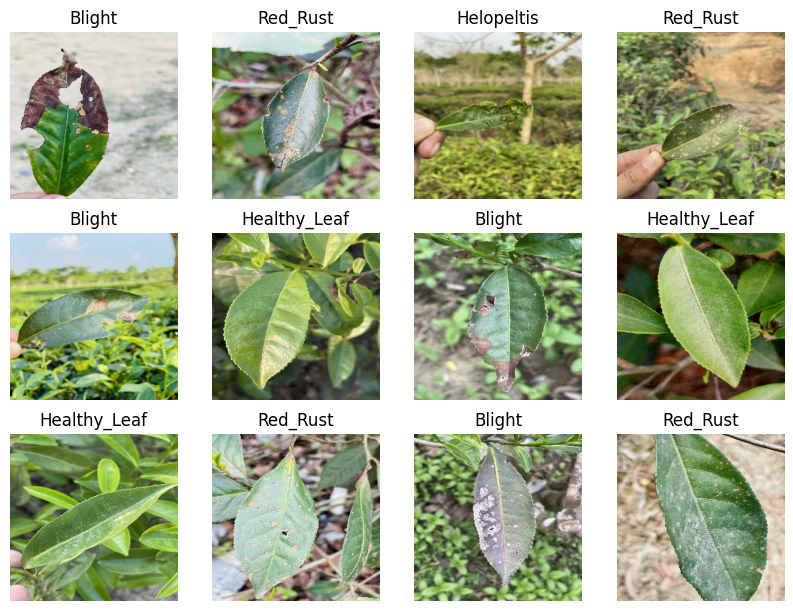

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in data_dir.take(2):
    for i in range(12):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
# Data loading and preprocessing
def load_data(data_dir, img_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """Load and preprocess data from directory"""
    images = []
    labels = []
    class_names = ['Blight', 'Healthy_Leaf', 'Helopeltis', 'Red_Rust']

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: {class_path} not found")
            continue

        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))]

        print(f"Loading {len(image_files)} images from {class_name}")

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype(np.float32) / 255.0

                images.append(img)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels), class_names

In [9]:
X, y, class_names = load_data(DATA_PATH)

Loading 555 images from Blight
Loading 650 images from Healthy_Leaf
Loading 675 images from Helopeltis
Loading 617 images from Red_Rust


In [10]:
print(f"Total samples: {len(X)}")
print(f"Image shape: {X.shape}")
print(f"Classes: {class_names}")

Total samples: 2497
Image shape: (2497, 256, 256, 3)
Classes: ['Blight', 'Healthy_Leaf', 'Helopeltis', 'Red_Rust']


In [11]:
# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print("\nClass distribution:")
for i, (class_idx, count) in enumerate(zip(unique, counts)):
    print(f"{class_names[class_idx]}: {count} samples")


Class distribution:
Blight: 555 samples
Healthy_Leaf: 650 samples
Helopeltis: 675 samples
Red_Rust: 617 samples


In [12]:
# Split data: 80% train, 10% val, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTrain samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Train samples: 1997
Validation samples: 250
Test samples: 250


In [13]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    # brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# No augmentation for validation and test
val_datagen = ImageDataGenerator()

In [14]:
from tensorflow.keras.utils import to_categorical

# One-hot encode labels
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Create data generators
batch_size = BATCH_SIZE
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)
test_generator = val_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

print(f"\nTrain generator batches: {len(train_generator)}")
print(f"Validation generator batches: {len(val_generator)}")
print(f"Test generator batches: {len(test_generator)}")


Train generator batches: 63
Validation generator batches: 8
Test generator batches: 8


In [15]:
num_classes = y_train.shape[1]

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             

 Total params: 28,414,276 (108.39 MB)

 Trainable params: 8,389,892 (32.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [16]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_vgg19_model.h5", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

In [17]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)
# Evaluate the model on the test set

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.4329 - loss: 1.3987

63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4349 - loss: 1.3939 - val_accuracy: 0.7160 - val_loss: 0.7686 - learning_rate: 1.0000e-04
Epoch 2/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.6929 - loss: 0.7731

63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 595ms/step - accuracy: 0.6932 - loss: 0.7725 - val_accuracy: 0.7440 - val_loss: 0.6308 - learning_rate: 1.0000e-04
Epoch 3/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.7588 - loss: 0.6538

63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 589ms/step - accuracy: 0.7589 - loss: 0.6536 - val_accuracy: 0.7880 - val_loss: 0.6116 - learning_rate: 1.0000e-04
Epoch 4/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.7735 - loss: 0.5965

63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 579ms/step - accuracy: 0.7736 - loss: 0.5962 - val_accuracy: 0.7920 - val_loss: 0.5573 - learning_rate: 1.0000e-04
Epoch 5/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.7830 - loss: 0.5523

63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 596ms/step - accuracy: 0.7829 - loss: 0.5523 - val_accuracy: 0.7920 - val_loss: 0.5426 - learning_rate: 1.0000e-04
Epoch 6/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.8081 - loss: 0.5059

63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 591ms/step - accuracy: 0.8081 - loss: 0.5058 - val_accuracy: 0.8000 - val_loss: 0.4987 - learning_rate: 1.0000e-04
Epoch 7/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 583ms/step - accuracy: 0.8052 - loss: 0.5154 - val_accuracy: 0.7720 - val_loss: 0.5612 - learning_rate: 1.0000e-04
Epoch 8/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.8213 - loss: 0.4813

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 576ms/step - accuracy: 0.8212 - loss: 0.4811 - val_accuracy: 0.8200 - val_loss: 0.4840 - learning_rate: 1.0000e-04
Epoch 9/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8495 - loss: 0.4199

63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 576ms/step - accuracy: 0.8493 - loss: 0.4202 - val_accuracy: 0.8320 - val_loss: 0.4475 - learning_rate: 1.0000e-04
Epoch 10/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 570ms/step - accuracy: 0.8252 - loss: 0.4431 - val_accuracy: 0.8160 - val_loss: 0.4802 - learning_rate: 1.0000e-04
Epoch 11/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 587ms/step - accuracy: 0.8413 - loss: 0.4211 - val_accuracy: 0.8280 - val_loss: 0.4508 - learning_rate: 1.0000e-04
Epoch 12/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.8500 - loss: 0.4198

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 576ms/step - accuracy: 0.8500 - loss: 0.4196 - val_accuracy: 0.8520 - val_loss: 0.4408 - learning_rate: 1.0000e-04
Epoch 13/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.8513 - loss: 0.3777

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 577ms/step - accuracy: 0.8511 - loss: 0.3780 - val_accuracy: 0.8600 - val_loss: 0.4341 - learning_rate: 1.0000e-04
Epoch 14/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8592 - loss: 0.3986

63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 616ms/step - accuracy: 0.8593 - loss: 0.3983 - val_accuracy: 0.8280 - val_loss: 0.4334 - learning_rate: 1.0000e-04
Epoch 15/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.8689 - loss: 0.3707

63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 600ms/step - accuracy: 0.8688 - loss: 0.3707 - val_accuracy: 0.8480 - val_loss: 0.3963 - learning_rate: 1.0000e-04
Epoch 16/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.8702 - loss: 0.3426

63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 581ms/step - accuracy: 0.8702 - loss: 0.3428 - val_accuracy: 0.8760 - val_loss: 0.3822 - learning_rate: 1.0000e-04
Epoch 17/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 566ms/step - accuracy: 0.8566 - loss: 0.3970 - val_accuracy: 0.8760 - val_loss: 0.3986 - learning_rate: 1.0000e-04
Epoch 18/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 587ms/step - accuracy: 0.8804 - loss: 0.3320 - val_accuracy: 0.8360 - val_loss: 0.4038 - learning_rate: 1.0000e-04
Epoch 19/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 579ms/step - accuracy: 0.8801 - loss: 0.3218 - val_accuracy: 0.8400 - val_loss: 0.3892 - learning_rate: 1.0000e-04
Epoch 20/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.8692 - loss: 0.3386

63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 580ms/step - accuracy: 0.8695 - loss: 0.3383 - val_accuracy: 0.8720 - val_loss: 0.3570 - learning_rate: 1.0000e-05
Epoch 21/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.9028 - loss: 0.2910

63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 588ms/step - accuracy: 0.9027 - loss: 0.2910 - val_accuracy: 0.8840 - val_loss: 0.3505 - learning_rate: 1.0000e-05
Epoch 22/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.9053 - loss: 0.2685

63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 588ms/step - accuracy: 0.9052 - loss: 0.2687 - val_accuracy: 0.8880 - val_loss: 0.3476 - learning_rate: 1.0000e-05
Epoch 23/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9091 - loss: 0.2767

63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 584ms/step - accuracy: 0.9091 - loss: 0.2767 - val_accuracy: 0.8960 - val_loss: 0.3442 - learning_rate: 1.0000e-05
Epoch 24/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.9030 - loss: 0.2652

63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 583ms/step - accuracy: 0.9030 - loss: 0.2653 - val_accuracy: 0.8960 - val_loss: 0.3418 - learning_rate: 1.0000e-05
Epoch 25/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 577ms/step - accuracy: 0.9077 - loss: 0.2690 - val_accuracy: 0.8880 - val_loss: 0.3462 - learning_rate: 1.0000e-05
Epoch 26/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.8990 - loss: 0.2910

63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 673ms/step - accuracy: 0.8989 - loss: 0.2909 - val_accuracy: 0.8960 - val_loss: 0.3410 - learning_rate: 1.0000e-05
Epoch 27/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.8990 - loss: 0.2796

63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 591ms/step - accuracy: 0.8992 - loss: 0.2794 - val_accuracy: 0.8960 - val_loss: 0.3398 - learning_rate: 1.0000e-05
Epoch 28/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.9024 - loss: 0.2686

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 575ms/step - accuracy: 0.9024 - loss: 0.2686 - val_accuracy: 0.8960 - val_loss: 0.3395 - learning_rate: 1.0000e-05
Epoch 29/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.8960 - loss: 0.2696

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 681ms/step - accuracy: 0.8961 - loss: 0.2695 - val_accuracy: 0.8960 - val_loss: 0.3368 - learning_rate: 1.0000e-05
Epoch 30/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 575ms/step - accuracy: 0.9061 - loss: 0.2665 - val_accuracy: 0.8640 - val_loss: 0.3441 - learning_rate: 1.0000e-05
Epoch 31/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 564ms/step - accuracy: 0.8991 - loss: 0.2671 - val_accuracy: 0.8880 - val_loss: 0.3412 - learning_rate: 1.0000e-05
Epoch 32/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 576ms/step - accuracy: 0.9010 - loss: 0.2703 - val_accuracy: 0.8960 - val_loss: 0.3379 - learning_rate: 1.0000e-05
Epoch 33/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 563ms/step - accuracy: 0.9156 - loss: 0.2654 - val_accuracy: 0.9040 - val_loss: 0.3374 - learning_rate: 1.0000e-06
Epoch 34/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 582ms/step - accuracy: 0.8976 - loss: 0.2699 - val_accuracy: 0.9040 - val_loss: 0.3371 - learning_rate: 1.0000e-06


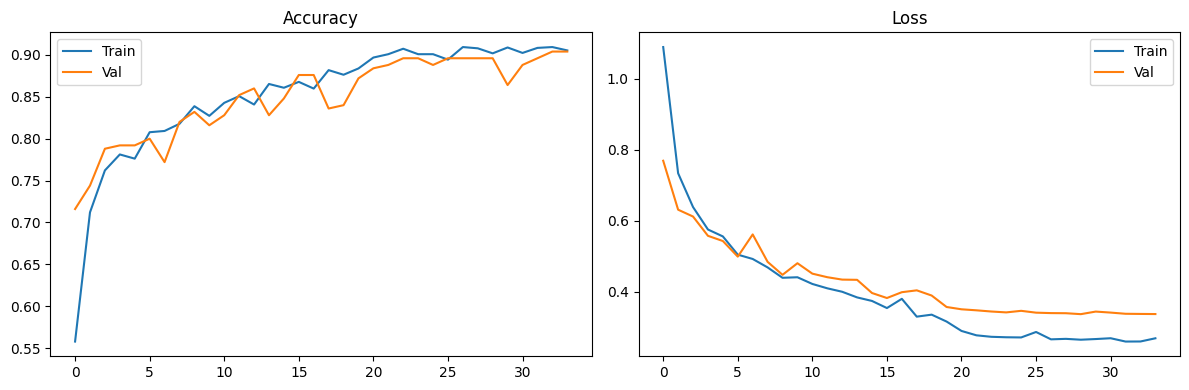

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)  # ✅ get true class labels from one-hot

class_names = ['Blight', 'Healthy_Leaf', 'Helopeltis', 'Red_Rust']  # ✅ manually add

print(classification_report(y_true, y_pred, target_names=class_names))


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step
              precision    recall  f1-score   support

      Blight       0.88      0.91      0.89        56
Healthy_Leaf       0.96      0.98      0.97        65
  Helopeltis       0.94      0.94      0.94        67
    Red_Rust       0.90      0.84      0.87        62

    accuracy                           0.92       250
   macro avg       0.92      0.92      0.92       250
weighted avg       0.92      0.92      0.92       250



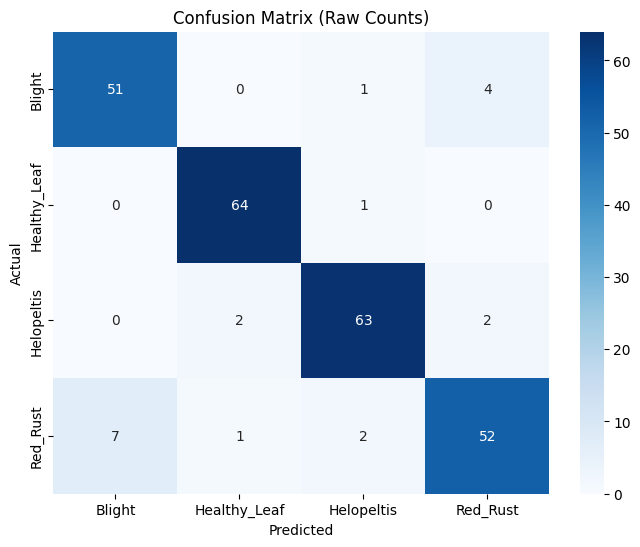

In [20]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


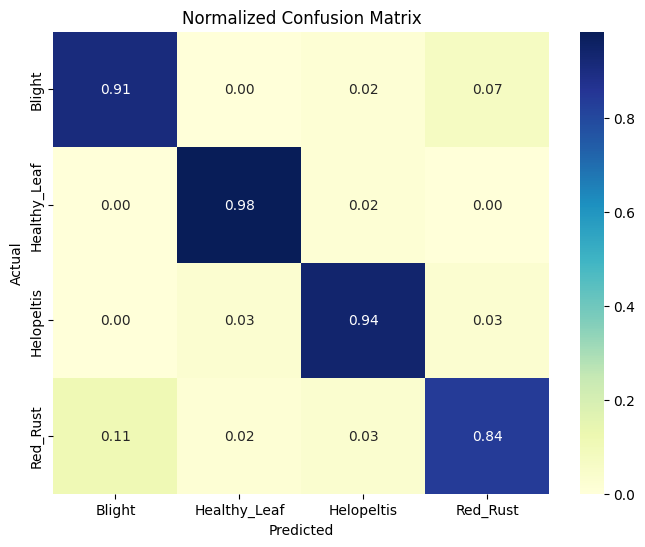

In [21]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", xticklabels=class_names, yticklabels=class_names, cmap='YlGnBu')
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


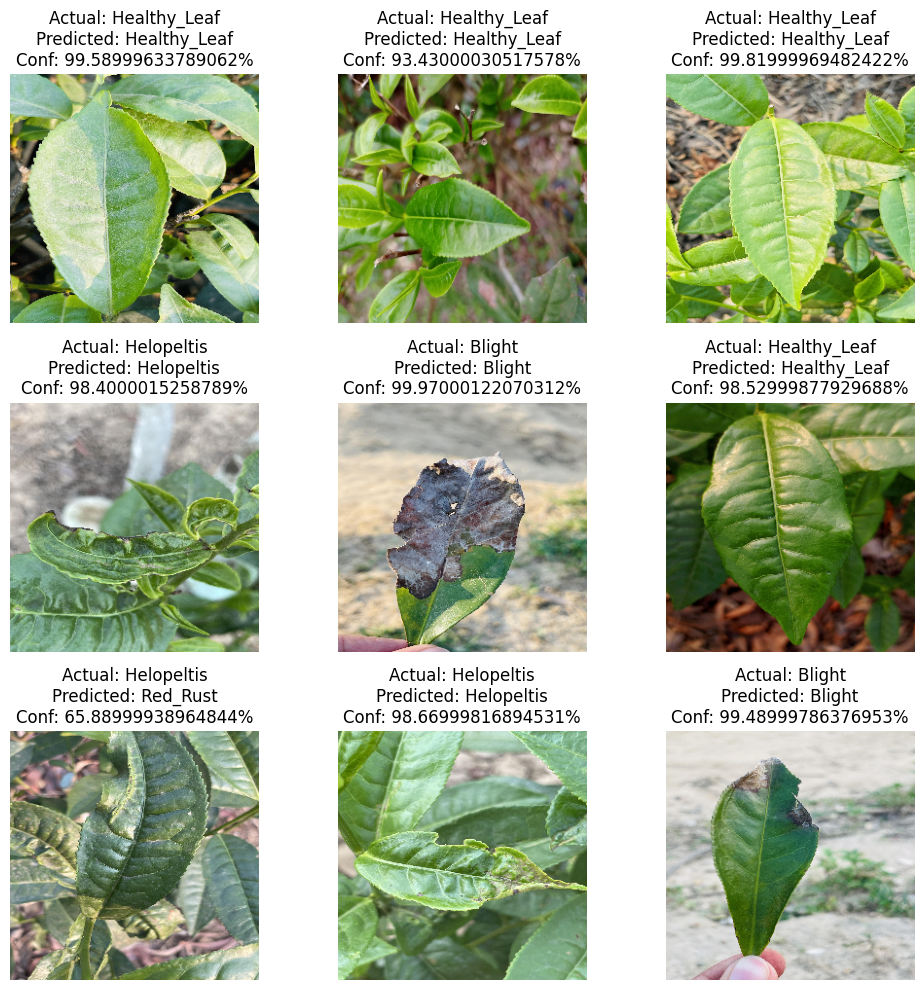

In [22]:
class_names = ['Blight', 'Healthy_Leaf', 'Helopeltis', 'Red_Rust']

def predict(model, img):
    img_array = tf.expand_dims(img, 0)
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * np.max(prediction[0]), 2)
    return predicted_class, confidence

images, labels = next(test_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = (images[i] * 255).astype("uint8")
    actual_class = class_names[np.argmax(labels[i])]
    predicted_class, confidence = predict(model, images[i])
    plt.imshow(img)
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConf: {confidence}%")
    plt.axis("off")

plt.tight_layout()
plt.show()


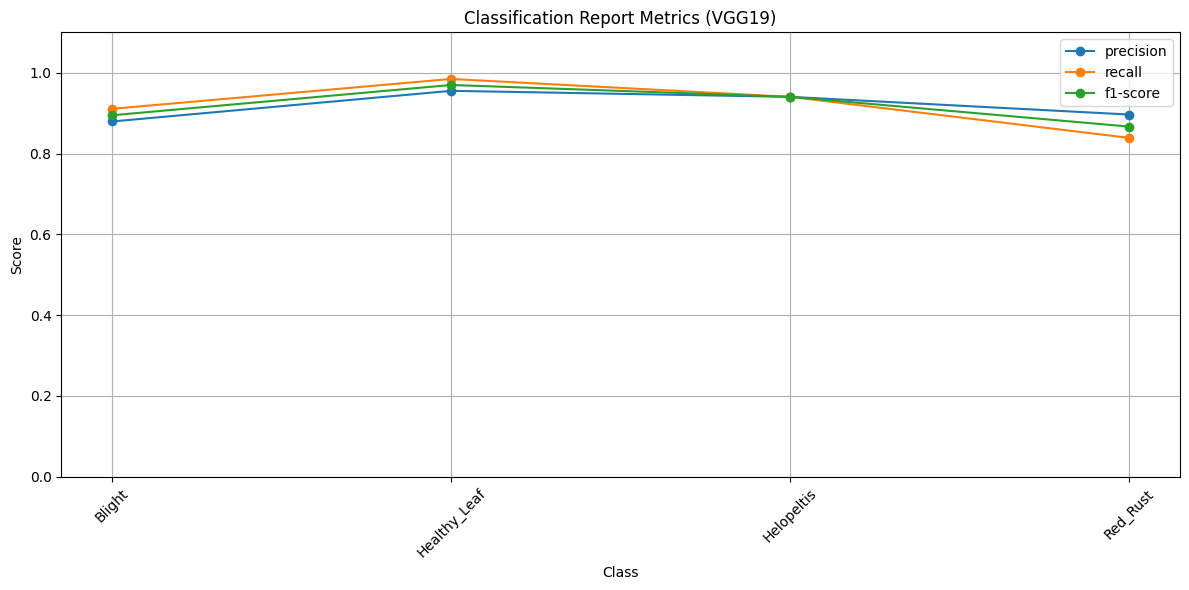

In [23]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Plot precision, recall, f1-score for each class
metrics = ['precision', 'recall', 'f1-score']
plt.figure(figsize=(12, 6))

for metric in metrics:
    scores = [report[cls][metric] for cls in class_names]
    plt.plot(class_names, scores, marker='o', label=metric)

plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.title("Classification Report Metrics (VGG19)")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
